In [1]:
import datetime
import re
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pymysql
import seaborn as sns
from matplotlib import style
import pandas.io.formats.style 
sns.set(style="darkgrid")

con = pymysql.connect('localhost', 'root', 'Karelia', 'geo_data')

In [2]:
def read_db():
    con.connect()
    
    select_main = con.cursor()
    select_main.callproc('vantaa_weather_all')
    data = select_main.fetchall()
    weather = pd.DataFrame(data)
    
    select_main.execute('show fields from vantaa_weather;')
    db_columns = select_main.fetchall()
    columns = [i[0] for i in db_columns]
    weather.columns = columns
    
    con.commit()
    
    weather.columns = columns
    weather.index = weather['record']
    weather = weather.drop(columns='record')
    
    return weather

In [3]:
weather = read_db()

In [4]:
def all_years(weather):
    position = []
    ticks = []
    
    for pos,tup in enumerate(weather.groupby([weather.index.year,weather.index.month]).aggregate({'temp':['max','mean','min']}).index.to_list()):
        if tup[1] == 11:
            label= (str(tup[0])+'-'+str(tup[1]))
            ticks.append(label)
            position.append(pos)
    weather.groupby([weather.index.year,weather.index.month]).aggregate({'temp':['max','mean','min']}).plot(ax=ax)
    ax.legend(['high','mean','low'])
    plt.xticks(position,ticks)
    plt.title('high, mean, low temperatures from Helsinki-Vantaa airport: November 1, 2008 - December 31, 2020')
    ax.set_xlabel("year-month")
    ax.set_ylabel("centigrade")
    

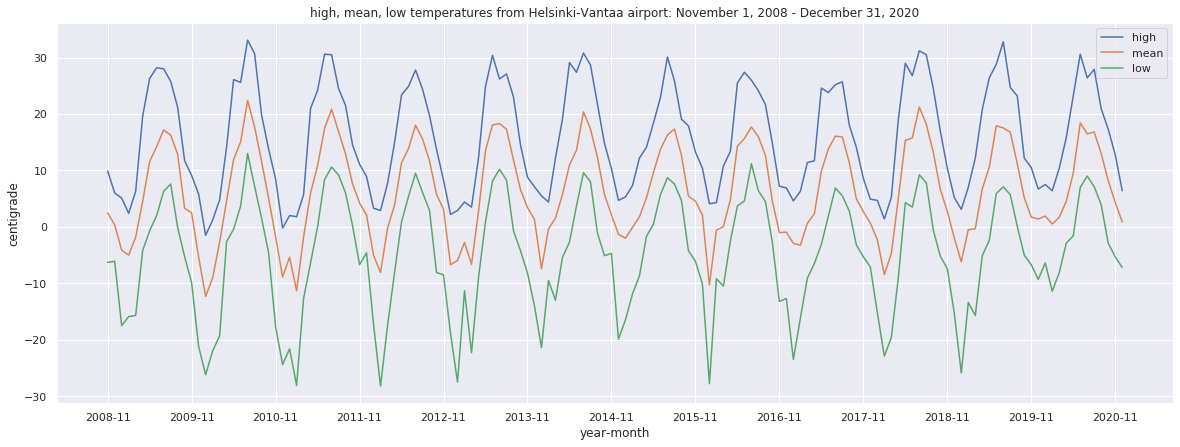

In [5]:
fig, ax = plt.subplots(figsize=(20, 7))

all_years(weather)

In [6]:
def get_annual(weather):
    annual = weather.resample('d').aggregate({'temp':['min','mean','max'],'snow':'mean'})
    annual = annual.groupby([annual.index.month,annual.index.day]).mean()
    
    ranger = pd.date_range(start='1/1/2020', end='12/31/2020')
    ranger = ranger.strftime('%b-%d')

    position = []
    ticks = []

    for pos, index in enumerate(ranger):
        if '01' in index:
            position.append(pos)
            ticks.append(index)
        elif index == 'Dec-31':
            position.append(pos)
            ticks.append(index)
    
    annual.index = ranger
    annual.columns = ['min','mean','max','snow']
    annual.loc[annual['snow'] == 0,'snow'] = np.nan
    
    annual['max_border'] = annual['max']
    annual['max_border'][annual['max_border'] >= 0] = 0
    annual['min_border'] = annual['min']
    annual['min_border'][annual['min_border'] >= 0] = 0

    annual['max_border2'] = annual['max']
    annual['max_border2'][annual['max_border2'] <= 0] = 0
    annual['min_border2'] = annual['min']
    annual['min_border2'][annual['min_border2'] <= 0] = 0
    
    
    ax2 = ax.twinx()
    ax2.fill_between(annual.index,annual.snow,zorder=1,alpha=.5,color='lightblue',label='mean snow cover')
    ax2.plot(annual.index,annual.snow,zorder=1,color='lightblue')
    ax2.grid(b=None)
    
    
    ax.plot(annual.index,annual['min'].values,zorder=2,label='min')
    ax.plot(annual.index,annual['mean'].values,zorder=2,label='mean')
    ax.plot(annual.index,annual['max'].values,zorder=2,label='max',color='red',alpha=.6)

    ax.fill_between(annual.index,annual['max_border'], annual['min_border'],color=['#7BB6FF'],linestyle='--',linewidth=0,label='winter threshold',zorder=2)
    ax.fill_between(annual.index,annual['max_border2'], annual['min_border2'],color=['#FEF9C7'],linestyle='--',linewidth=0,label='warming period',zorder=2)

    ax.set_zorder(ax.get_zorder()+1)
    ax.patch.set_visible(False)
    ax2.patch.set_visible(True)

    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax2.tick_params(axis=u'both', which=u'both',length=0)

    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2)

    plt.title('annual mean: high, media, low temperatures from Helsinki-Vantaa airport: November 1, 2008 - December 31, 2020')
    ax.set_xlabel("month-day")
    ax.set_ylabel("centigrade")
    ax2.set_ylabel("snow cm")

    plt.xticks(position,ticks)

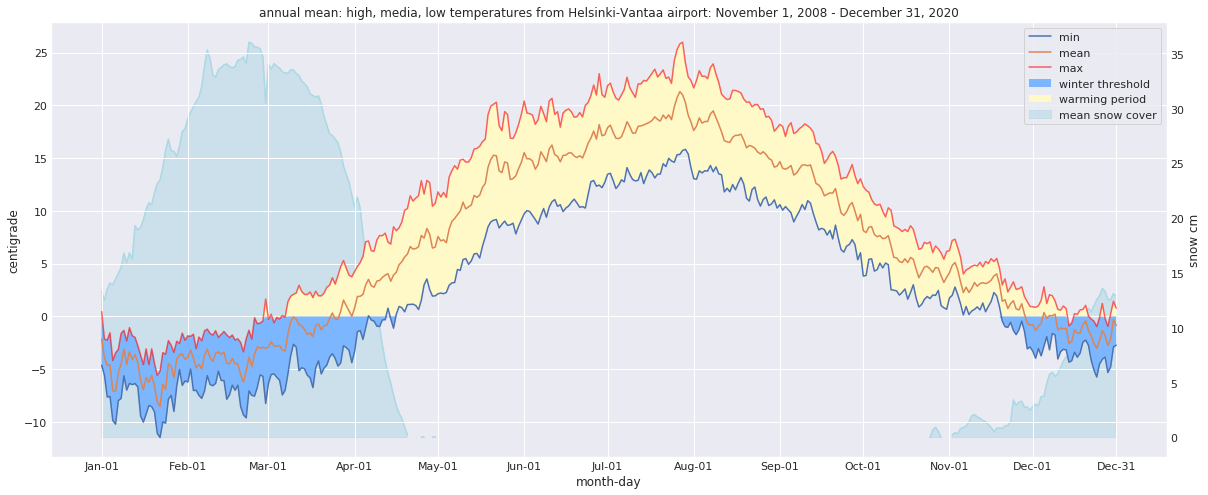

In [7]:
fig, ax = plt.subplots(figsize=(20, 8))
        
get_annual(weather)

In [8]:
def get_climate_avg():
    link = "https://en.wikipedia.org/wiki/Vantaa"
    ref_table = pd.read_html(link)[1]
    ref_table = ref_table.iloc[0:6]
    ref_table = ref_table[ref_table.columns[0:13]]
    ref_table.columns = ref_table.columns.get_level_values(1)
    ref_table = ref_table.set_index('Month',drop=True)  
    ref_table = ref_table.applymap(lambda x: re.split("\(", x)[0]).applymap(lambda x: re.sub("−",'-', x))
    ref_table = ref_table.swapaxes('index','columns')
    ref_table = ref_table.applymap(pd.to_numeric)
    
    return ref_table

In [9]:
ref_table= get_climate_avg()

In [10]:
def variance(weather,ref_table):
    change = weather['2009':].resample('d').aggregate({'temp':['max','mean','min']}).round(2).dropna()
    change = change.groupby(change.index.year).mean()
    change.columns = ['max','mean','min']

    ax.bar(change.index,change['max'].values,color='#669900',alpha=.3)
    ax.bar(change.index,change['mean'].values,color='#ffeecc',alpha=.8)
    ax.bar(change.index,change['min'].values,color='#3366ff',alpha=1)
    ax.plot(change.index,(change.mean(axis=1) - ref_table[ref_table.columns[1:4]].mean(axis=1).mean()),color='red',marker='o', linestyle='dashed')

    plt.xticks(change.index)
    ax.legend(['annual increase: centigrade','high','median','min'],loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_xlabel("year")
    ax.set_ylabel("centigrade")

    for year, value in dict(change.mean(axis=1) - ref_table[ref_table.columns[1:4]].mean(axis=1).mean()).items():
        if value <0:
            ax.annotate(str(value.round(2)),xy=(year, value.round(2)),xytext=(year, value.round(2)+.5),horizontalalignment='center')
        else:
            ax.annotate('+'+str(value.round(2)),xy=(year, value.round(2)),xytext=(year, value.round(2)+.5),horizontalalignment='center')

    plt.title('mean minimum, median, maximum annual temperature: with mean deviation per year')

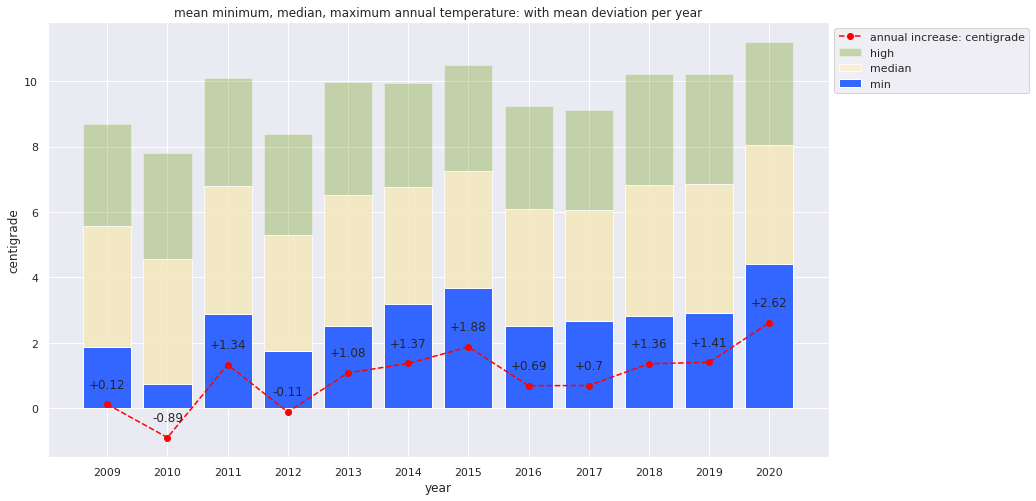

In [11]:
fig, ax = plt.subplots(figsize=(14, 8))

variance(weather,ref_table)

In [27]:
def winter(weather):
    winter = weather[(weather.index.month.isin([11,12,1,2,3]))].resample('d').aggregate({'temp':'mean','snow':'mean'}).copy()
    winter = winter.dropna()
    winter = pd.pivot_table(winter,index=[winter.index.month,winter.index.day],columns=[winter.index.year])
    tuples = list(zip(winter.columns.get_level_values(0),[str(i) +'-'+ str(i + 1)[2:] for i in winter.columns.get_level_values(1)]))
    winter.columns = pd.MultiIndex.from_tuples(tuples, names=["value", "period"])
    winter = winter.loc[(11,1):(12,31)].append(winter.loc[(1,1):(3,31)].shift(periods=-1, axis="columns"))
    return winter

In [28]:
winter = winter(weather)

In [29]:
def summer_variance(weather,ref_table):
    summer_plot = weather[(weather.index.month.isin([5,6,7,8]))].resample('d').aggregate({'temp':'mean','dew':'mean','precip':'sum','msl':'mean','clouds':'mean','wind_speed':'mean','wind_dir':'mean'}).copy()
    summer_plot = pd.pivot_table(summer_plot,index=[summer_plot.index.month],columns=summer_plot.index.year,values='temp')
    summer_plot.index = pd.to_datetime(summer_plot.index, format='%m').month_name()
    summer_plot.plot.bar(cmap='summer',ax=ax)
    plt.title('mean temperature during summer months: with variance')
    ax.set_xlabel("month")
    ax.set_ylabel("centigrade")
    ax.plot(summer_plot.index,ref_table.iloc[4:8]['Daily mean °C (°F)'].values,color='red',marker='*', linestyle='--',markersize=12,label='climate average')
    
    for pos, value in enumerate(ref_table.iloc[4:8]['Daily mean °C (°F)']):
        ax.annotate('+'+str(value),xy=(pos,value),xytext=(pos,value+1),horizontalalignment='center',bbox=dict(boxstyle="Square", fc="white",alpha=.5))

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation='horizontal')

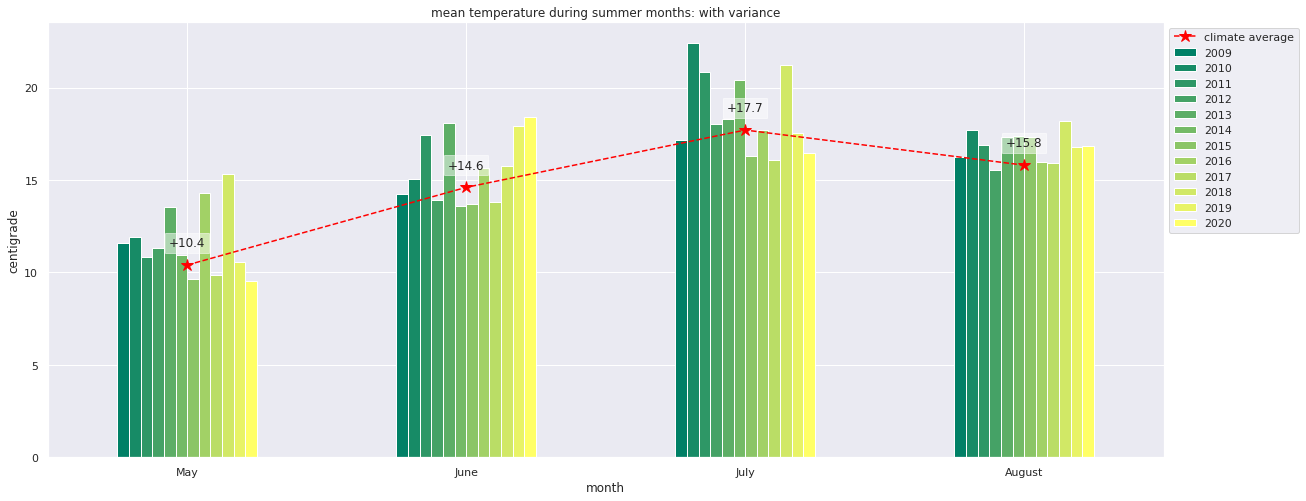

In [30]:
fig, ax = plt.subplots(figsize=(20, 8))
summer_variance(weather,ref_table)

In [31]:
def winter_plot(winter,ref_table):
    framer = pd.DataFrame(ref_table.iloc[10:].append(ref_table.iloc[:3])['Daily mean °C (°F)']).set_index([pd.Index([11,12, 1, 2,3])])
    framer = framer.rename({framer.columns[0]:'climate average'},axis=1)
    framer = winter['temp'].groupby(winter['temp'].index.get_level_values(0),sort=False).mean().join(framer)
    framer.index  = pd.to_datetime(framer.index, format='%m').month_name()

    framer[framer.columns[:13]].plot.bar(legend=False,cmap='winter',ax=ax)
    framer[framer.columns[13]].plot(ax=ax,color='red',marker='*', linestyle='--',markersize=12)
    
    for position,value in enumerate(framer['climate average'].values):
        if value > 0:
            ax.annotate('+'+str(value),xy=(position,value),xytext=(position,value+1),horizontalalignment='center',bbox=dict(boxstyle="Square", fc="white",alpha=.5))
        else:
            ax.annotate(str(value),xy=(position,value),xytext=(position,value+1),horizontalalignment='center',bbox=dict(boxstyle="Square", fc="white",alpha=.5))
   
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    ax.set_xlabel("month")
    ax.set_ylabel("centigrade")
    plt.title('mean monthly temperature: winter months, with climate average')

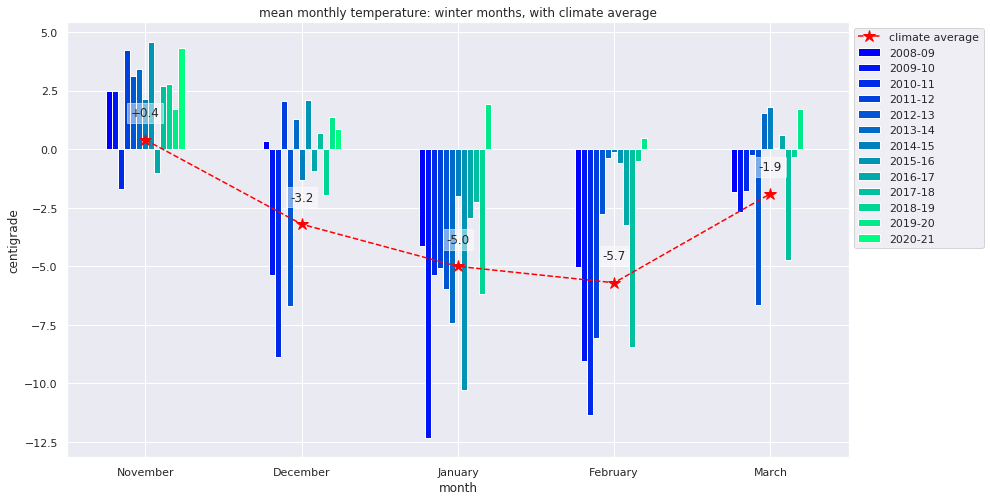

In [32]:
fig, ax = plt.subplots(figsize=(14, 8))

winter_plot(winter,ref_table)

In [33]:
def neg(val):
    if val > 5:
        color = "#10d54b"
    elif val > 2 and val <= 5:
        color = '#C8FBD7' 
    elif val > .5 and val <= 2:
        color = '#E7FFEE'
    elif val > -.5 and val <= .5:
         color = 'white'
    elif val < -.5 and val > -5:
        color = ' #cceeff' 
    elif val < -5 and val > -10:
        color = '#99ddff'
    elif val <= -10:
        color = '#66ccff'
    else:
        color = '#FFFFFF'
    return 'background-color: %s' % color

In [34]:
def annual_month_variance(weather,ref_table):
    annual_month = pd.pivot_table(weather,index=weather.index.month,columns=weather.index.year,values='temp',aggfunc='mean')
    annual_month.index=  pd.to_datetime(annual_month.index, format='%m').month_name()
    annual_month = annual_month[annual_month.columns[1:]]
    annual_month = annual_month.sub(ref_table[['Daily mean °C (°F)']].values, axis='columns').style.format( '{:+.2f}').applymap(neg)
    annual_month.index.name = 'month'
    annual_month.columns.name = 'year'
    return annual_month

In [35]:
annual_month_variance(weather,ref_table)

year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
month,,,,,,,,,,,,
January,+0.86,-7.31,-0.38,-0.06,-0.96,-2.42,+2.98,-5.29,+2.07,+2.73,-1.19,+6.91
February,+0.69,-3.36,-5.63,-2.38,+2.95,+5.32,+5.60,+5.12,+2.45,-2.76,+5.19,+6.20
March,+0.08,-0.80,+0.10,+1.67,-4.74,+3.44,+3.69,+1.94,+2.53,-2.84,+1.57,+3.61
April,+0.39,+0.55,+1.93,-0.25,-1.36,+1.66,+1.02,+0.74,-1.77,+0.94,+2.66,+0.42
May,+1.19,+1.52,+0.44,+0.95,+3.11,+0.55,-0.75,+3.89,-0.54,+4.91,+0.17,-0.87
June,-0.38,+0.46,+2.84,-0.71,+3.47,-1.02,-0.88,+1.05,-0.79,+1.16,+3.31,+3.82
July,-0.51,+4.70,+3.15,+0.31,+0.59,+2.68,-1.42,+0.01,-1.62,+3.53,-0.16,-1.22
August,+0.47,+1.90,+1.10,-0.24,+1.50,+1.56,+1.55,+0.18,+0.12,+2.38,+0.97,+1.01
September,+2.17,+0.89,+2.21,+1.01,+1.17,+1.62,+2.01,+1.98,+0.66,+2.52,+0.51,+2.27


In [36]:
def annual_month_total(weather):
    annual_month_total = pd.pivot_table(weather,index=weather.index.month,columns=weather.index.year,values='temp',aggfunc='mean')
    annual_month_total.index=  pd.to_datetime(annual_month_total.index, format='%m').month_name()
    annual_month_total = annual_month_total[annual_month_total.columns[1:]]
    annual_month_total = annual_month_total.style.format( '{:+.2f}').background_gradient(cmap='bwr',axis=None,vmax=27)
    annual_month_total.index.name = 'month'
    annual_month_total.columns.name = 'year'
    return annual_month_total

In [37]:
annual_month_total(weather)

year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
month,,,,,,,,,,,,
January,-4.14,-12.31,-5.38,-5.06,-5.96,-7.42,-2.02,-10.29,-2.93,-2.27,-6.19,+1.91
February,-5.01,-9.06,-11.33,-8.08,-2.75,-0.38,-0.10,-0.58,-3.25,-8.46,-0.51,+0.50
March,-1.82,-2.70,-1.80,-0.23,-6.64,+1.54,+1.79,+0.04,+0.63,-4.74,-0.33,+1.71
April,+4.49,+4.65,+6.03,+3.85,+2.74,+5.76,+5.12,+4.84,+2.33,+5.04,+6.76,+4.52
May,+11.59,+11.92,+10.84,+11.35,+13.51,+10.95,+9.65,+14.29,+9.86,+15.31,+10.57,+9.53
June,+14.22,+15.06,+17.44,+13.89,+18.07,+13.58,+13.72,+15.65,+13.81,+15.76,+17.91,+18.42
July,+17.19,+22.40,+20.85,+18.01,+18.29,+20.38,+16.28,+17.71,+16.08,+21.23,+17.54,+16.48
August,+16.27,+17.70,+16.90,+15.56,+17.30,+17.36,+17.35,+15.98,+15.92,+18.18,+16.77,+16.81
September,+12.87,+11.59,+12.91,+11.71,+11.87,+12.32,+12.71,+12.68,+11.36,+13.22,+11.21,+12.97


In [38]:
def get_annual_variance(weather):
    style_table = weather.groupby(weather.index.year).mean().drop(columns=['precip','snow']).round(2)
    style_table = style_table.join(weather.resample('d').aggregate({'precip':'sum'}).resample('Y').sum().set_index([pd.Index(weather.index.year.unique())]))
    style_table = style_table.join(winter['snow'].mean(axis=0).to_frame().set_index([pd.Index(weather.index.year.unique())]).rename({0:'daily mean snow'},axis=1))
    style_table = style_table.iloc[1:]
    style_table = style_table[['temp','humid','msl','clouds','wind_gust','wind_dir','precip','daily mean snow']]
    style_table = style_table.style.format( '{:.2f}').highlight_max(color='orange').highlight_min(color='lightblue')
    return style_table

In [39]:
get_annual_variance(weather)

,temp,humid,msl,clouds,wind_gust,wind_dir,precip,daily mean snow
record,,,,,,,,
2009,5.56,80.10,1013.20,61.89,5.87,178.08,599.50,34.91
2010,4.56,78.49,1013.12,65.46,5.81,171.03,499.40,49.61
2011,6.81,77.61,1012.14,58.35,6.29,194.82,705.00,25.48
2012,5.31,80.53,1012.15,65.37,6.27,184.04,867.70,49.12
2013,6.53,79.75,1012.97,58.02,6.15,194.46,573.40,2.71
2014,6.76,81.01,1015.11,61.99,6.01,179.13,629.70,7.05
2015,7.26,80.98,1012.05,58.73,6.55,204.83,681.80,7.65
2016,6.09,81.23,1013.22,61.67,6.14,195.94,789.50,9.43
2017,6.07,82.02,1010.80,63.07,6.30,197.53,833.30,11.86


In [40]:
def wind_cent_hex(weather):
    hb = ax.hexbin(weather['temp'].values, weather['wind_dir'].values, gridsize=50,mincnt=1,cmap='bwr')
    ax.set_title("correlative binning of wind direction and temperature: daily values,  November 1, 2008 - December 31, 2020")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('counts')
    ax.set_xlabel("centigrade")
    ax.set_ylabel("wind direction")

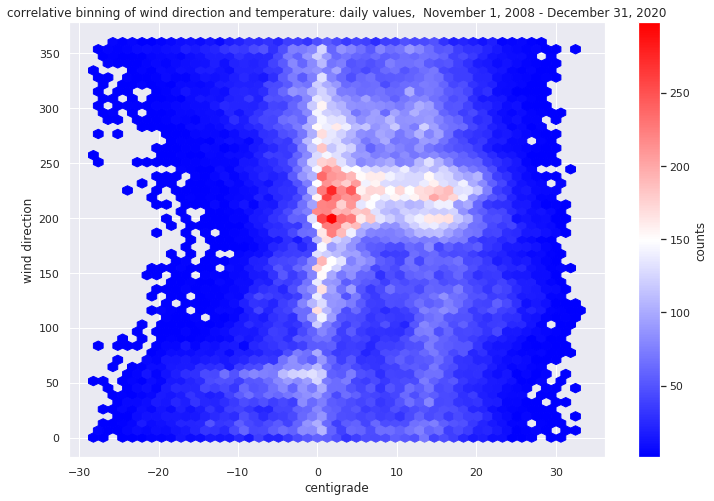

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
wind_cent_hex(weather)

In [42]:
def mslp_cent_hex(weather):
    hb = ax.hexbin(weather['temp'].values, weather['msl'].values, gridsize=50,mincnt=1,cmap='bwr')
    ax.set_title("correlative binning of mean sea level pressure and temperature: daily values, November 1, 2008 - December 31, 2020")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('counts')
    ax.set_xlabel("centigrade")
    ax.set_ylabel("mean sea level pressure")

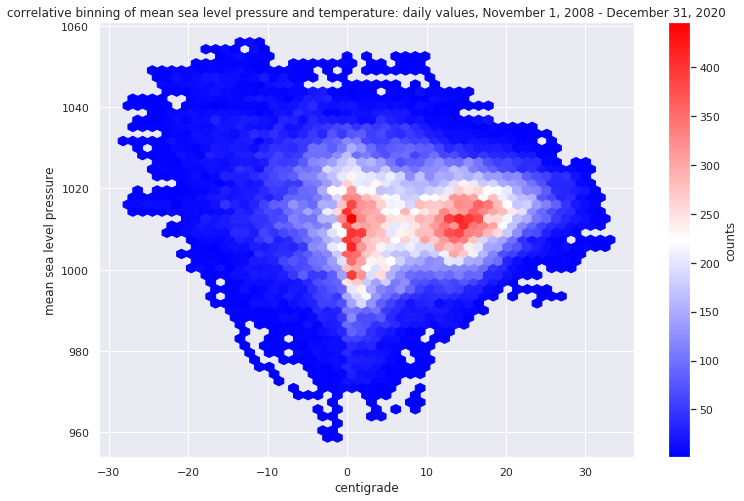

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
mslp_cent_hex(weather)

In [44]:
def wind_mslp_cent_hex(weather):
    hb = ax.hexbin(weather['temp'].values, weather['wind_dir'].values, gridsize=30,C=weather['msl'].values,mincnt=1,cmap='bwr')
    ax.set_title("correlative binning of mean sea level pressure and temperature: daily values, November 1, 2008 - December 31, 2020")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('mean sea level pressure')
    ax.set_xlabel("centigrade")
    ax.set_ylabel("wind direction")

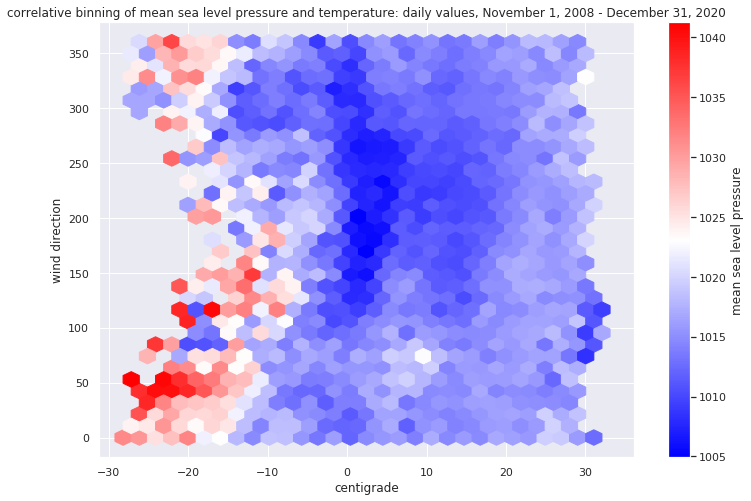

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
wind_mslp_cent_hex(weather)